### Import libraries

In [1]:
import sys
sys.path.append("..")
from model import classic_model, combined_model, experimental_model, losses, grapher
from data import data_generation, batch_creator, gp_kernels, gp_priors, loader
from helpers import helpers, plotter, masks
from keras.callbacks import ModelCheckpoint
from inference import infer
import tensorflow as tf; import keras
import time
import numpy as np

Using TensorFlow backend.


In [2]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [3]:
# pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(150000, ordered = False, same_x = True)

In [4]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te = loader.load_data()

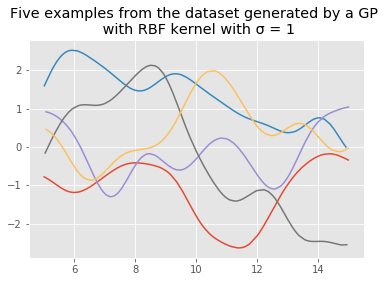

In [5]:
plotter.plot_examples(pad_pos_tr, pad_y_fren_tr)

In [6]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [7]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)
# batch_pos_tr1 = batch_pos_tr[:, :-1]
# batch_pos_tr_current = batch_pos_tr[:, 1:]

In [8]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=30)
# batch_pos_tr1 = batch_pos_tr[:, :-1]
# batch_pos_tr_current = batch_pos_tr[:, 1:]

Already exists
Restored from /Users/omernivron/Downloads/GPT/ckpt/check_4321/ckpt-95
Tensor("decoder/Squeeze:0", shape=(64, 199, 2), dtype=float64)
Tensor("decoder/Squeeze:0", shape=(64, 199, 2), dtype=float64)


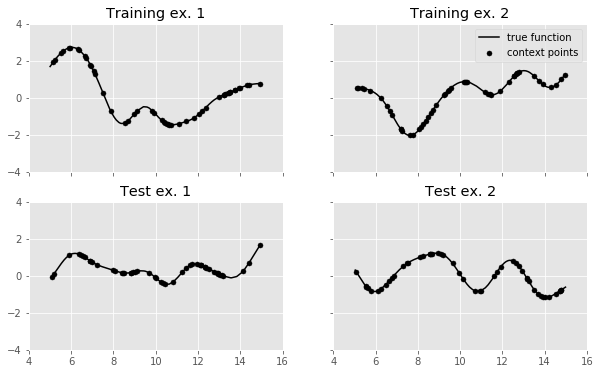

Epoch 0 batch 0 train Loss 0.1963 test Loss 0.2153 with training MSE metric 0.4038 and testing MSE metric 0.4346


In [ ]:
if __name__ == '__main__':
    writer = tf.summary.create_file_writer(save_dir + '/logs/')
    optimizer_c = tf.keras.optimizers.Adam(3e-4)
    decoder = experimental_model.Decoder(32, num_heads = 4); tf.random.set_seed(443)   
    EPOCHS = 75; batch_s  = 64; run = 4321; step = 0
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
#     num_batches = 1500
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + str(run); helpers.mkdir(folder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    with writer.as_default():
        for epoch in range(EPOCHS):

            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                m_te.reset_states(); test_loss.reset_states()
                batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=64)
                batch_pos_tr1 = batch_pos_tr[:, :-1]
                batch_pos_tr_current = batch_pos_tr[:, 1:]
                pred, pred_log, weights, names = train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr, batch_tar_tr)
#                 print(pred.shape)
                
                if batch_n % 300 == 0:
                    pos_te_current = pad_pos_te[:, 1:]
                    pred_te, pred_log_te = test_step(decoder, test_loss, m_te, pad_pos_te[:500, :], pad_y_fren_te[:500, :])
                    plotter.follow_training_plot(batch_pos_tr, batch_tar_tr, pred, pad_pos_te[:500, :], pad_y_fren_te[:500, :], pred_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [ ]:
pred.numpy()[np.array([2, 59]), :
            ].shape

In [ ]:
pred[:, 198]

In [ ]:
198-49+1

In [ ]:
pad_pos_te.shape[1]

In [ ]:
len(batch_pos_tr)